# IRIS QNN - Blind Quantum Computing

(Versão Binária)
Este notebook executa o código de Blind Quantum Computing utilizando Qiskit. O objetivo é demonstrar como rodar experimentos quânticos de forma segura e privada, utilizando um dataset de exemplo (Iris).

In [1]:
# INSTALE AS DEPEDÊNCIAS
!pip install matplotlib qiskit qiskit-machine-learning scikit-learn torch pandas seaborn

   ---------------------------------------- 0.0/11.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.3 MB 1.4 MB/s eta 0:00:09
   ---------------------------------------- 0.1/11.3 MB 991.0 kB/s eta 0:00:12
    --------------------------------------- 0.1/11.3 MB 1.2 MB/s eta 0:00:10
   - -------------------------------------- 0.3/11.3 MB 2.0 MB/s eta 0:00:06
   - -------------------------------------- 0.5/11.3 MB 2.3 MB/s eta 0:00:05
   -- ------------------------------------- 0.6/11.3 MB 2.5 MB/s eta 0:00:05
   --- ------------------------------------ 1.1/11.3 MB 3.7 MB/s eta 0:00:03
   ------ --------------------------------- 1.8/11.3 MB 5.3 MB/s eta 0:00:02
   ---------- ----------------------------- 2.9/11.3 MB 7.3 MB/s eta 0:00:02
   --------------- ------------------------ 4.5/11.3 MB 10.3 MB/s eta 0:00:01
   ----------------------------- ---------- 8.2/11.3 MB 17.0 MB/s eta 0:00:01
   ---------------------------------------  11.3/11.3 MB 43.5 MB/s eta 0:00:01



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\Dreysv\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
# instalar as bibliotecas necessárias

from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.primitives import Estimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns  
import collections
from quantumnet.components import Network, Logger
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error

import itertools

%matplotlib inline

In [3]:
def plot_confusion_matrix(y_true, y_pred, class_names=None):

    # Calcula a matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    
    # Cria a visualização manualmente
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plota a matriz como imagem
    cax = ax.matshow(cm, cmap='Blues', alpha=0.8)
    fig.colorbar(cax)
    
    # Adiciona os valores nas células
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, str(cm[i, j]), 
                   ha='center', va='center', 
                   fontsize=16, fontweight='bold',
                   color='white' if cm[i, j] > cm.max()/2 else 'black')
    
    # Configura os eixos
    if class_names is not None:
        ax.set_xticks(range(len(class_names)))
        ax.set_yticks(range(len(class_names)))
        ax.set_xticklabels(class_names)
        ax.set_yticklabels(class_names)
    
    ax.set_xlabel('Previsto', fontsize=12)
    ax.set_ylabel('Real', fontsize=12)
    ax.xaxis.set_label_position('top')
    
    plt.title('Matriz de Confusão - Classificador Quântico', fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()
    
    return cm


# Controle de Aleatoriedade e Reprodutibilidade
O trecho abaixo define uma semente fixa (SEED = 42) e a aplica nas bibliotecas random, numpy e torch. Isso garante que os resultados aleatórios (como inicialização de pesos e embaralhamento de dados) sejam os mesmos a cada execução do código, o que é essencial para fins de reprodutibilidade. 

Além disso, o uso de torch.use_deterministic_algorithms(True) força o PyTorch a utilizar apenas algoritmos determinísticos, evitando variações internas e tornando os experimentos mais consistentes e confiáveis.

In [4]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.use_deterministic_algorithms(True)

# Inicializar a rede

Hosts inicializados
Canais inicializados
Pares EPRs adicionados


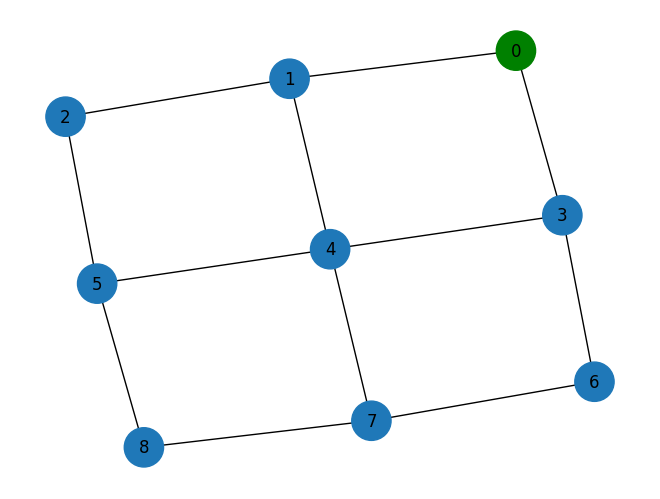

In [5]:
rede = Network()
rede.set_ready_topology('grade',8,3,3) 
rede.draw()
Logger.activate(Logger)

# Backend com Ruído

In [6]:
noise_model = NoiseModel()
error_1q = depolarizing_error(0.01, 1)  # 1% de erro para portas de 1 qubit
error_2q = depolarizing_error(0.02, 2)  # 2% de erro para portas de 2 qubits

noise_model.add_all_qubit_quantum_error(error_1q, ['h', 'x', 'y', 'z', 'rx', 'ry', 'rz'])
noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])

simulator = AerSimulator(
    noise_model=noise_model,
    shots=1024
)

estimator = Estimator(options={
    "backend": simulator,
    "resilience_level": 1,
    "approximation": True
})

C:\Users\Dreysv\AppData\Local\Temp\ipykernel_8700\1609314416.py:13: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator(options={


# Carrega o conjunto de dados Iris
- X → dados (características/features) 
- y → rótulos (classes/labels)

In [7]:
iris = load_iris()
X = iris.data 
y = iris.target

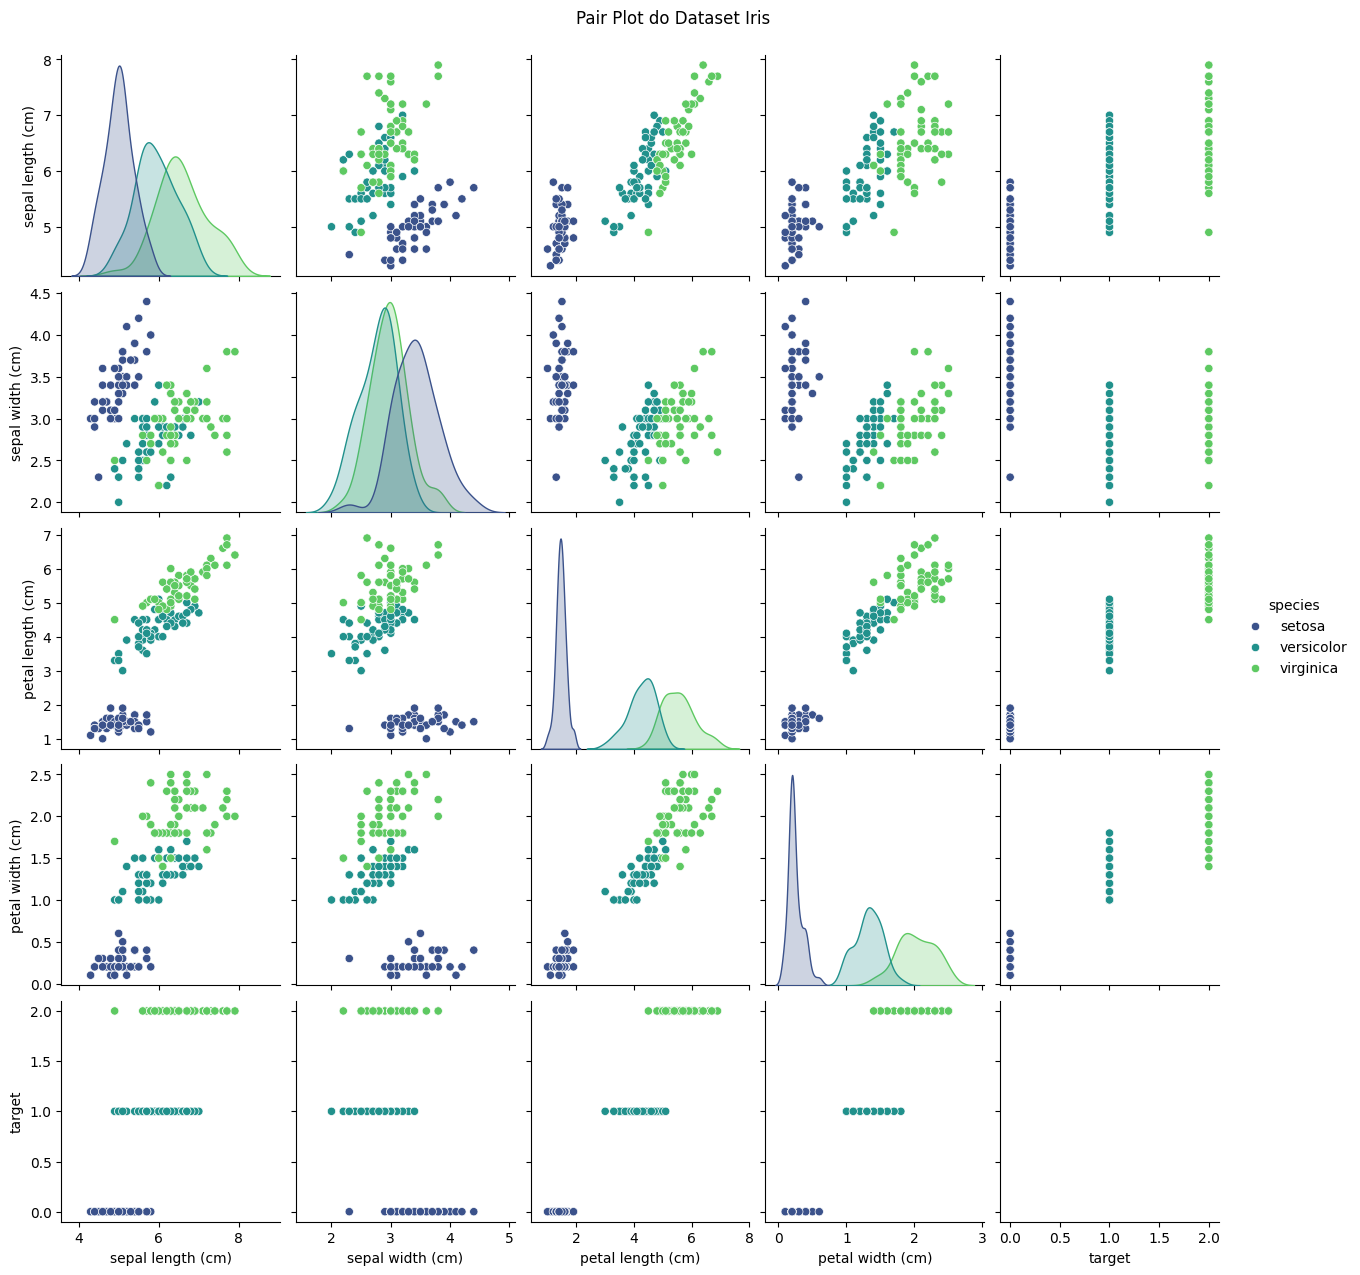

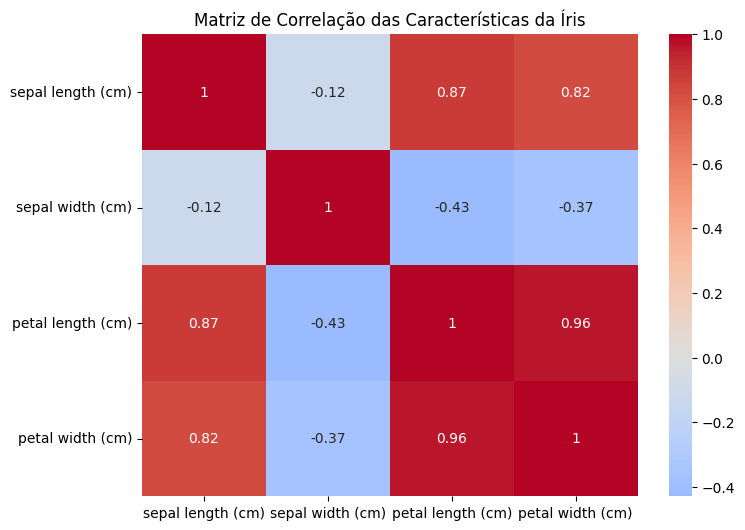

In [8]:
# Criar um DataFrame para facilitar a visualização
df = pd.DataFrame(X, columns=iris.feature_names)#
df['target'] = y#
df['species'] = df['target'].apply(lambda i: iris.target_names[i])#

# Criar o Pair Plot
sns.pairplot(df, hue='species', palette='viridis', height=2.5)#
plt.suptitle('Pair Plot do Dataset Iris', y=1.02)#
plt.show()#

plt.figure(figsize=(8, 6))#
correlation_matrix = df[iris.feature_names].corr()#
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)#
plt.title('Matriz de Correlação das Características da Íris')#
plt.show()#

# Reduz para duas classes (binário)
- o QNN padrão trabalha com 0/1

- Por isso, o conjunto Iris foi reduzido para apenas 2 classes, ou seja, só foram usados os exemplos das flores das espécies setosa e versicolor, excluindo a terceira (virginica).
- Porém, as características (ou variáveis de entrada) — como comprimento e largura da sépala e da pétala — foram mantidas.
- Isso significa que só simplificamos as saídas (as classes), mas não mexemos nas entradas.

- Essa decisão foi feita para simplificar o código e permitir um foco mais direto no funcionamento do QML (Quantum Machine Learning) com redes neurais quânticas.
- Embora seja possível adaptar o QNN para problemas multiclasse, isso exigiria um código mais avançado 

In [9]:
X = X[y != 2]
y = y[y != 2]

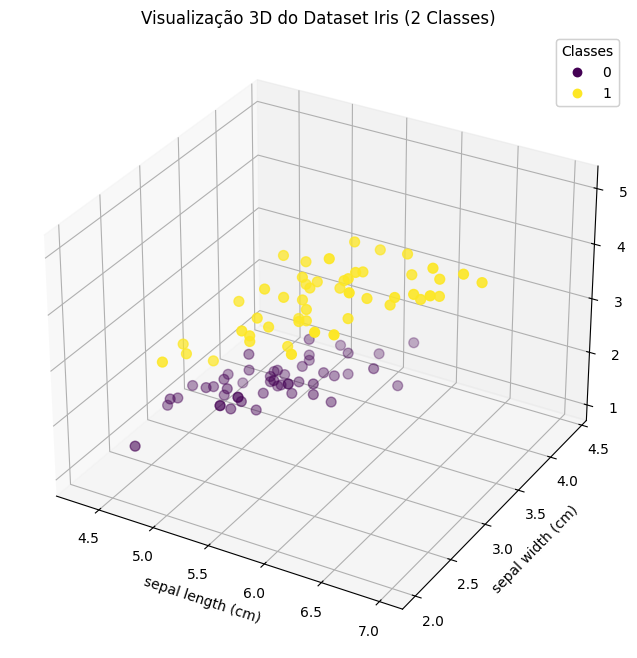

In [10]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], 
                     c=y, cmap='viridis', s=50)

ax.set_xlabel(iris.feature_names[0])
ax.set_ylabel(iris.feature_names[1])
ax.set_zlabel(iris.feature_names[2])
ax.set_title('Visualização 3D do Dataset Iris (2 Classes)')

legend = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend)

plt.show()

# Divide os dados 
80% treino e 20% teste

- test_size -> define que 20% dos dados serão usados para teste (logo, 80% vão para treino)
- random_state -> os dados são embaralhados aleatoriamente antes de dividir em treino e teste.
- stratify -> mantém a mesma proporção de cada classe nos conjuntos de treino e teste (boa prática em classificações)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

print("Distribuição das classes no y_train e y_test:")
print("Treino:", collections.Counter(y_train))
print("Teste:", collections.Counter(y_test))

Distribuição das classes no y_train e y_test:
Treino: Counter({np.int64(0): 40, np.int64(1): 40})
Teste: Counter({np.int64(1): 10, np.int64(0): 10})


# Normaliza os dados
- Normalizar = colocar tudo na mesma escala (de 0 a 1).
- Isso ajuda o modelo a aprender melhor e evita que uma variável "grite" mais que as outras.
- ex: Se uma variável vai de 0 a 1000 e outra vai de 0 a 1, a maior domina o aprendizado

In [12]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define número de qubits
- Se o conjunto de dados tem 4 features (ex: comprimento da pétala, largura da pétala etc),
- então são necessários 4 qubits para representar e processar cada uma dessas features no circuito quântico.

In [13]:
num_qubits = X_train.shape[1]

# Feature map e ansatz
- Feature Map → insere as features no circuito quântico
- RealAmplitudes → um tipo específico de ansatz do Qiskit, onde ele monta um circuito que trabalha com rotações e entrelaçamento. Isso faz com que ele consiga representar padrões/pesos diferentes nas features. "onde tem peso para aprender"

- Quantos mais os números de reps crescer mais a chance de overfitting (treinar de uma forma errada)

In [14]:
feature_map = ZZFeatureMap(feature_dimension=num_qubits)
ansatz = RealAmplitudes(num_qubits, reps=1)

# Cria o circuito
- etapa que cria um circuito quântico vazio, transforma os dados clássicos (números normais) em um estado quântico e ) e depois coloca o ansatz para o modelo conseguir aprender os padrões/pesos das features.


In [15]:
qc = QuantumCircuit(num_qubits)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

# EstimatorQNN
- Transforma o circuito (qc) em uma rede neural quântica treinável.

- E permite treinar ela usando PyTorch, igual uma rede neural clássica.

In [16]:
qnn = EstimatorQNN(circuit=qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, estimator=estimator) 
model = TorchConnector(qnn)

C:\Users\Dreysv\AppData\Local\Temp\ipykernel_8700\2150709190.py:1: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(circuit=qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, estimator=estimator)


# Otimização com PyTorch
- X_train_tensor e y_train_tensor → Convertem os dados de treino (X_train e y_train) de NumPy pra tensor do PyTorch, que é o formato que o modelo entende.

- optimizer = torch.optim.Adam(...) → Define o otimizador Adam, que ajusta os pesos do modelo pra minimizar o erro.

- lr=0.1 → Taxa de aprendizado (velocidade que ele ajusta os pesos com base nos erros, não pode ser muito alto e não muito baixo).

- loss_func = torch.nn.BCELoss() → Função de perda para problemas de classificação binária — mede o erro entre a saída do modelo (probabilidade) e o valor real (0 ou 1).

In [17]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
loss_func = torch.nn.BCELoss()

# Treinamento
- model.train() → Coloca o modelo no modo treino
- optimizer.zero_grad() → Zera os gradientes dos cálculos anteriores pra não acumular.
- outputs = model(X_train_tensor) →  usa os dados de treino no modelo para fazer uma previsão/estimativa.
- loss → calcula o erro
- loss.backward() → Calcula os gradientes, ou seja, descobre pra onde e quanto cada peso deve mudar pra reduzir o erro.
- optimizer.step() → usa esses gradientes pra mudar os pesos do ansatz. Ele faz isso pra tentar diminuir o erro na próxima vez que roda

In [18]:
for epoch in range(5):
    model.train()
    total_loss = 0.0

    optimizer.zero_grad()

    output = model(X_train_tensor)
    prediction = torch.sigmoid(output.squeeze())
    loss = loss_func(prediction, y_train_tensor)
    loss.backward()
    optimizer.step()

    trained_weights = model.weight.detach().numpy()

    final_circuit = QuantumCircuit(num_qubits)
    final_circuit.compose(feature_map, inplace=True)
    final_circuit.compose(ansatz.assign_parameters(trained_weights), inplace=True)

    total_loss += loss.item()

    quantum_circuit = final_circuit
    circuit_depth = quantum_circuit.depth()

    rede.application_layer.run_app(
        "AC_BQC",
        alice_id=6,
        bob_id=0,
        num_qubits=num_qubits,
        scenario=2,
        circuit_depth=circuit_depth
        )

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

2025-09-03 13:52:06,574: Timeslot 0: Iniciando protocolo Andrew Childs entre Alice 6 e Bob 0.
2025-09-03 13:52:06,575: Limpando a memória do cliente (Alice) antes de iniciar o protocolo.
2025-09-03 13:52:06,575: Limpando a memória do servidor (Bob) antes de iniciar o protocolo.
2025-09-03 13:52:06,577: Cliente criou 4 qubits para a transmissão.
2025-09-03 13:52:06,579: Qubit 344 registrado no timeslot 0
2025-09-03 13:52:06,580: Qubit 389 registrado no timeslot 0
2025-09-03 13:52:06,580: Qubit 867 registrado no timeslot 0
2025-09-03 13:52:06,581: Qubit 270 registrado no timeslot 0
2025-09-03 13:52:06,581: Qubit 344 criado pelo Cliente - Estado: 0, Fase: 1
2025-09-03 13:52:06,582: Qubit 389 criado pelo Cliente - Estado: 0, Fase: 1
2025-09-03 13:52:06,582: Qubit 867 criado pelo Cliente - Estado: 0, Fase: 1
2025-09-03 13:52:06,583: Qubit 270 criado pelo Cliente - Estado: 0, Fase: 1
2025-09-03 13:52:06,583: Alice recebeu 4 qubits. Total: 4 qubits na memória.
2025-09-03 13:52:06,583: Instruç

Tempo de Operação: 2
Epoch 1, Loss: 0.6550


2025-09-03 13:52:11,337: Timeslot 11: Iniciando protocolo Andrew Childs entre Alice 6 e Bob 0.
2025-09-03 13:52:11,338: Limpando a memória do cliente (Alice) antes de iniciar o protocolo.
2025-09-03 13:52:11,338: Limpando a memória do servidor (Bob) antes de iniciar o protocolo.
2025-09-03 13:52:11,339: Cliente criou 4 qubits para a transmissão.
2025-09-03 13:52:11,339: Qubit 996 registrado no timeslot 11
2025-09-03 13:52:11,340: Qubit 80 registrado no timeslot 11
2025-09-03 13:52:11,340: Qubit 849 registrado no timeslot 11
2025-09-03 13:52:11,340: Qubit 906 registrado no timeslot 11
2025-09-03 13:52:11,341: Qubit 996 criado pelo Cliente - Estado: 0, Fase: 1
2025-09-03 13:52:11,341: Qubit 80 criado pelo Cliente - Estado: 0, Fase: 1
2025-09-03 13:52:11,342: Qubit 849 criado pelo Cliente - Estado: 0, Fase: 1
2025-09-03 13:52:11,342: Qubit 906 criado pelo Cliente - Estado: 0, Fase: 1
2025-09-03 13:52:11,342: Alice recebeu 4 qubits. Total: 4 qubits na memória.
2025-09-03 13:52:11,343: Inst

Epoch 2, Loss: 0.6399


2025-09-03 13:52:16,204: Timeslot 12: Iniciando protocolo Andrew Childs entre Alice 6 e Bob 0.
2025-09-03 13:52:16,205: Limpando a memória do cliente (Alice) antes de iniciar o protocolo.
2025-09-03 13:52:16,205: Limpando a memória do servidor (Bob) antes de iniciar o protocolo.
2025-09-03 13:52:16,205: Cliente criou 4 qubits para a transmissão.
2025-09-03 13:52:16,206: Qubit 46 registrado no timeslot 12
2025-09-03 13:52:16,206: Qubit 791 registrado no timeslot 12
2025-09-03 13:52:16,208: Qubit 81 registrado no timeslot 12
2025-09-03 13:52:16,209: Qubit 887 registrado no timeslot 12
2025-09-03 13:52:16,209: Qubit 46 criado pelo Cliente - Estado: 0, Fase: 1
2025-09-03 13:52:16,210: Qubit 791 criado pelo Cliente - Estado: 0, Fase: 1
2025-09-03 13:52:16,211: Qubit 81 criado pelo Cliente - Estado: 0, Fase: 1
2025-09-03 13:52:16,211: Qubit 887 criado pelo Cliente - Estado: 0, Fase: 1
2025-09-03 13:52:16,212: Alice recebeu 4 qubits. Total: 4 qubits na memória.
2025-09-03 13:52:16,213: Instru

Epoch 3, Loss: 0.6257


2025-09-03 13:52:20,907: Timeslot 13: Iniciando protocolo Andrew Childs entre Alice 6 e Bob 0.
2025-09-03 13:52:20,908: Limpando a memória do cliente (Alice) antes de iniciar o protocolo.
2025-09-03 13:52:20,908: Limpando a memória do servidor (Bob) antes de iniciar o protocolo.
2025-09-03 13:52:20,909: Cliente criou 4 qubits para a transmissão.
2025-09-03 13:52:20,909: Qubit 166 registrado no timeslot 13
2025-09-03 13:52:20,909: Qubit 214 registrado no timeslot 13
2025-09-03 13:52:20,910: Qubit 718 registrado no timeslot 13
2025-09-03 13:52:20,910: Qubit 663 registrado no timeslot 13
2025-09-03 13:52:20,910: Qubit 166 criado pelo Cliente - Estado: 0, Fase: 1
2025-09-03 13:52:20,911: Qubit 214 criado pelo Cliente - Estado: 0, Fase: 1
2025-09-03 13:52:20,911: Qubit 718 criado pelo Cliente - Estado: 0, Fase: 1
2025-09-03 13:52:20,912: Qubit 663 criado pelo Cliente - Estado: 0, Fase: 1
2025-09-03 13:52:20,912: Alice recebeu 4 qubits. Total: 4 qubits na memória.
2025-09-03 13:52:20,912: In

Epoch 4, Loss: 0.6129


2025-09-03 13:52:25,912: Timeslot 14: Iniciando protocolo Andrew Childs entre Alice 6 e Bob 0.
2025-09-03 13:52:25,913: Limpando a memória do cliente (Alice) antes de iniciar o protocolo.
2025-09-03 13:52:25,914: Limpando a memória do servidor (Bob) antes de iniciar o protocolo.
2025-09-03 13:52:25,914: Cliente criou 4 qubits para a transmissão.
2025-09-03 13:52:25,915: Qubit 250 registrado no timeslot 14
2025-09-03 13:52:25,915: Qubit 388 registrado no timeslot 14
2025-09-03 13:52:25,915: Qubit 947 registrado no timeslot 14
2025-09-03 13:52:25,916: Qubit 570 registrado no timeslot 14
2025-09-03 13:52:25,916: Qubit 250 criado pelo Cliente - Estado: 0, Fase: 1
2025-09-03 13:52:25,917: Qubit 388 criado pelo Cliente - Estado: 0, Fase: 1
2025-09-03 13:52:25,917: Qubit 947 criado pelo Cliente - Estado: 0, Fase: 1
2025-09-03 13:52:25,917: Qubit 570 criado pelo Cliente - Estado: 0, Fase: 1
2025-09-03 13:52:25,918: Alice recebeu 4 qubits. Total: 4 qubits na memória.
2025-09-03 13:52:25,918: In

Epoch 5, Loss: 0.6019


# Avaliação
- Primeiro ele, Faz previsão no conjunto de teste, sem atualizar o modelo.
- Transforma saída em probabilidade e decide se é classe 0 ou 1.
- Prepara os resultados para análise (cálculo das métricas).
# Métricas
- Acurácia: porcentagem de previsões corretas (tanto verdadeiros positivos quanto verdadeiros negativos).

- Precisão: proporção de previsões positivas que estavam corretas (foca em evitar falsos positivos).

- Recall: proporção de casos positivos corretamente identificados (foca em evitar falsos negativos).


GERANDO MATRIZ DE CONFUSÃO...


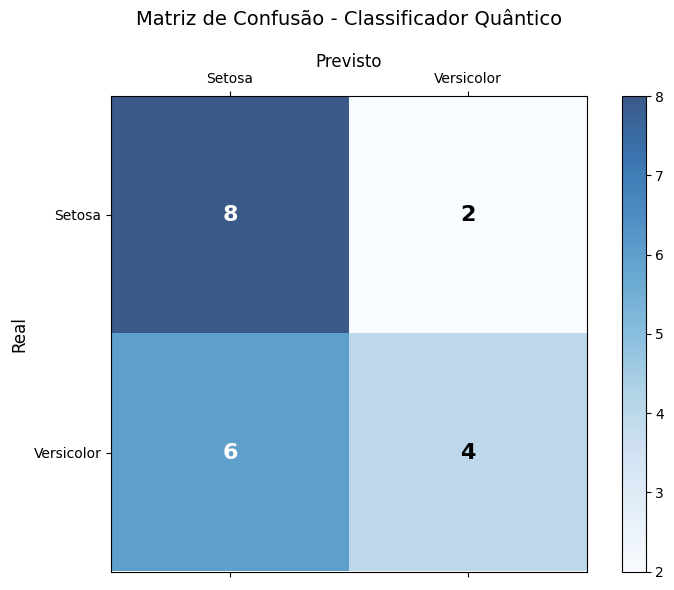

MÉTRICAS:
Acurácia: 0.60
Precisão: 0.67
Recall: 0.40
F1: 0.50


In [19]:
#acontece de forma transparente e não encapsulado como o vqc
with torch.no_grad():
    outputs = model(torch.tensor(X_test, dtype=torch.float32)).squeeze()
    y_pred = torch.sigmoid(outputs).round().numpy()

print("\nGERANDO MATRIZ DE CONFUSÃO...")
cm = plot_confusion_matrix(y_test, y_pred, class_names=['Setosa', 'Versicolor'])

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("MÉTRICAS:")
print(f"Acurácia: {accuracy:.2f}")
print(f"Precisão: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1: {f1:.2f}")

## Conclusões e próximos passos

- O experimento de Blind Quantum Computing foi executado com sucesso.
- Próximos passos podem incluir: testar outros datasets, aprimorar o circuito quântico, ou analisar a segurança do protocolo.